# Предсказание цен на недвижимость

В проекте нам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве — `median_house_value`, обучить модель и сделайте предсказания на тестовой выборке.  

Необходимо выполнить следующие пункты ТЗ:
- Использовать методы `Spark`.
- Для построения модели использовать оценщик `LinearRegression` из библиотеки `MLlib`. Для оценки качества модели требуется использовать метрики `RMSE`, `MAE` и `R2`.
- Построить две модели линейной регрессии на разных наборах данных:
  - используя все данные из файла;  
  - используя только числовые переменные, исключив категориальны.

## 1. Описание данных

Данные, которые мы будем анализировать, были собраны в рамках переписи населения в США. Каждая строка содержит агрегированную статистику о жилом массиве. Жилой массив — минимальная географическая единица с населением от 600 до 3000 человек в зависимости от штата. Одна строка в данных содержит статистику в среднем о 1425.5 обитателях жилого массива.

В колонках датасета содержатся следующие данные:

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

## 2. Знакомство с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
try:
    import phik
except:
    !pip install phik -q
    import phik

try:
    import pyspark
except:
    !pip install pyspark -q

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer,
    VectorAssembler,
    StandardScaler,
    Imputer
)
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator

In [4]:
sns.set()
RANDOM_STATE = 666
TEST_SIZE = 0.20
SAMPLE_SIZE = 1.0
np.random.seed(RANDOM_STATE)

Инициализируем локальную сессию и прочитаем данные из файла `/datasets/housing.csv` с помощью `pySpark`.

In [5]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("EDA California Housing") \
                    .getOrCreate()

df = spark.read.load('/datasets/housing.csv', format="csv", sep=",", inferSchema=True, header="true")
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Взглянем на данные.

In [6]:
# выведем названия колонок
display(pd.DataFrame(df.dtypes, columns=['column', 'type']))

# выведем первые 5 строк
df.show(5)

,column,type
0,longitude,double
1,latitude,double
2,housing_median_age,double
3,total_rooms,double
4,total_bedrooms,double
5,population,double
6,households,double
7,median_income,double
8,median_house_value,double
9,ocean_proximity,string


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

В большинстве колонок хранятся количественные данные, кроме одной — `ocean_proximity`. Она хранит категориальные значения. Разделим колонки на два типа: числовые и текстовые, которые представляют категориальные данные.

In [7]:
num_cols = ['longitude',
            'latitude',
            'housing_median_age',
            'total_rooms',
            'total_bedrooms',
            'population',
            'households',
            'median_income']
cat_cols = ['ocean_proximity']
target = 'median_house_value' 

## 3. Предобработка данных

Проверим данные на наличие пропусков.

In [8]:
# выведем пропущенные значения в каждой колонке
for column in df.columns:
    check_col = df[column].isNull()
    print(column, df.select(column).filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


В колонке `total_bedrooms` есть 207 пропусков, заполним их (и другие возможные пропуски в числовых признаках) медианными значениями в пайплайне с помощью инструмента `pyspark.ml.feature.Imputer`.

**Итак, мы познакомились с данными, они в целом соответствуют описанию. От пропусков мы избавимся в пайплайне, теперь приступим к исследованию признаков.**

## 4. Анализ признаков

Ознакомимся со статистическими характеристиками.

In [9]:
df.select(num_cols+[target]).describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0


Числовые признаки имеют разный масштаб и для использования в модели линейной регрессии нуждаются в масштабировании, которое мы осуществим в пайплайне.

Исследуем распределение целевого признака.


====== Признак median_house_value ======



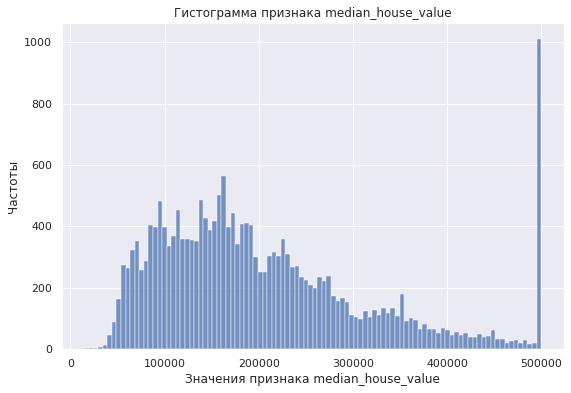

In [10]:
column = target
print(f'\n====== Признак {column} ======\n')
column_data = df.select(column).sample(SAMPLE_SIZE).toPandas()
fig, ax = plt.subplots(figsize=(9, 6));
plt.title(f'Гистограмма признака {column}');
plt.ylabel('Частоты');
plt.xlabel(f'Значения признака {column}');
sns.histplot(column_data,
            x=column,
            bins=100,
            ax=ax);
plt.show()

In [11]:
column_data.query('median_house_value == 500001')[column].count()

965

Распределение не является нормальным и смещено вправо. Имеется около тысячи значений 500001, что, скорее всего, является следствием того, что жилым массивам со значением целевого признака большим 500000 были присвоены значения 500001. Этот факт негативно скажется на предсказательной способности линейной регрессии, обученной на всех данных.

Взглянем на распределения числовых признаков.


====== Признак longitude ======



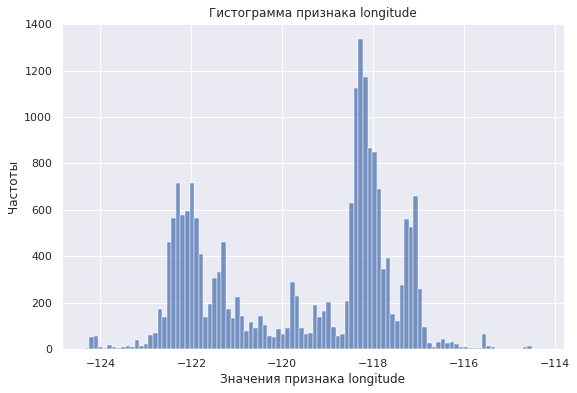

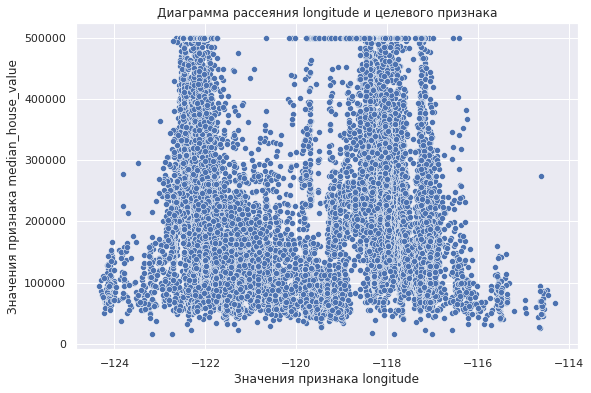


====== Признак latitude ======



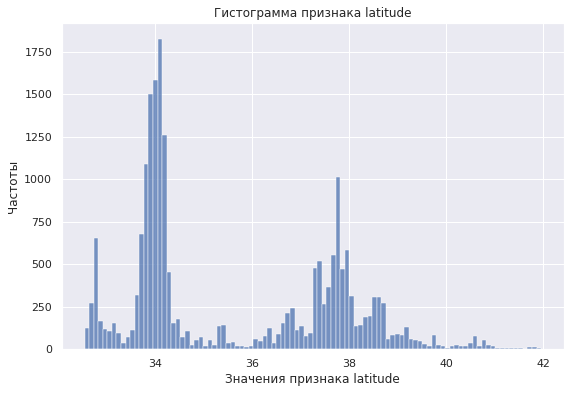

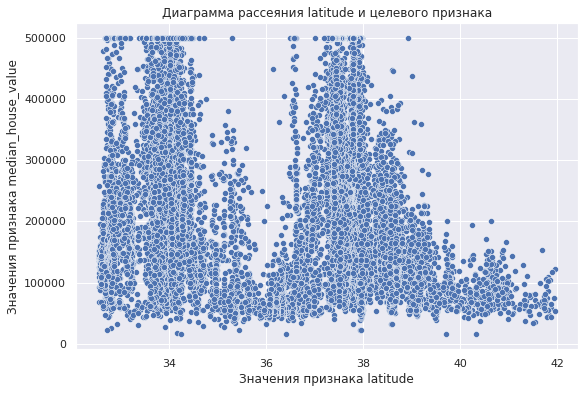


====== Признак housing_median_age ======



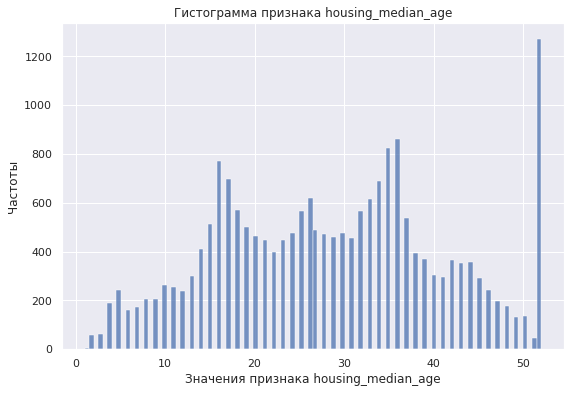

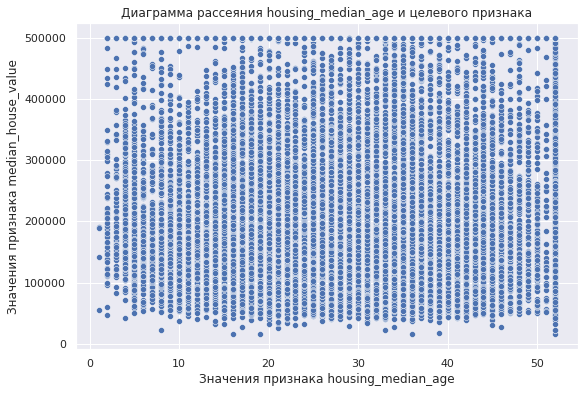


====== Признак total_rooms ======



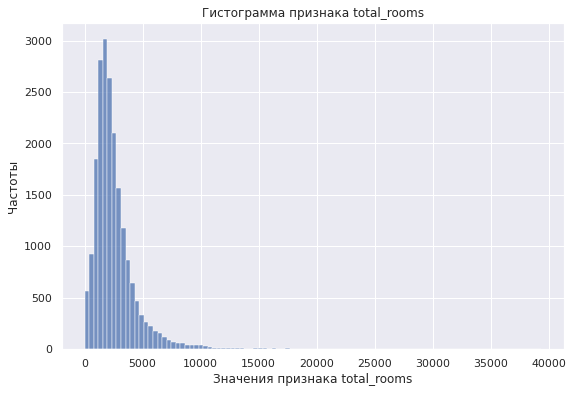

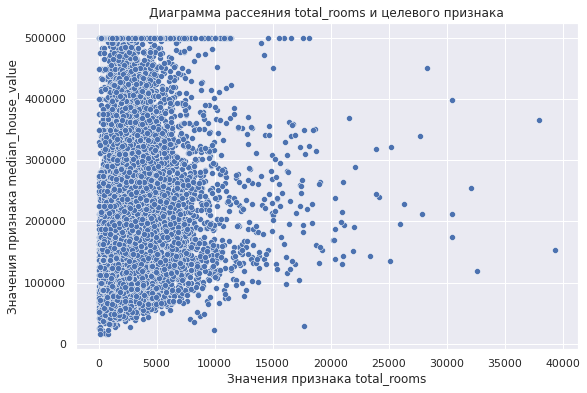


====== Признак total_bedrooms ======



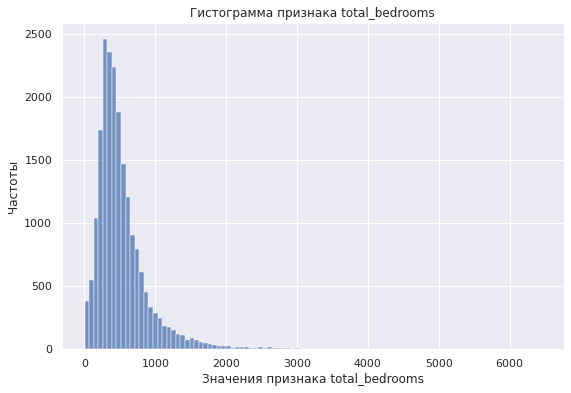

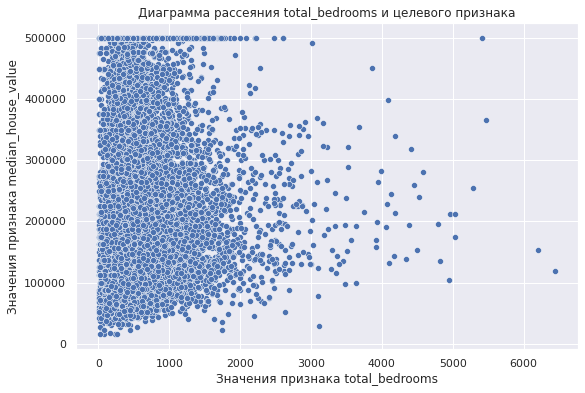


====== Признак population ======



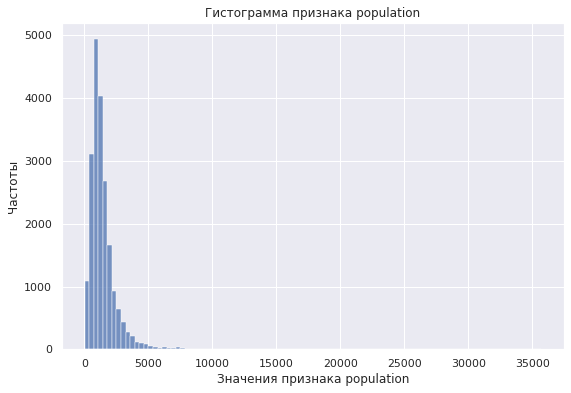

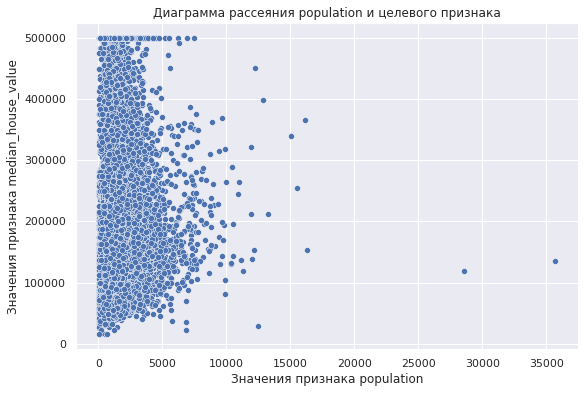


====== Признак households ======



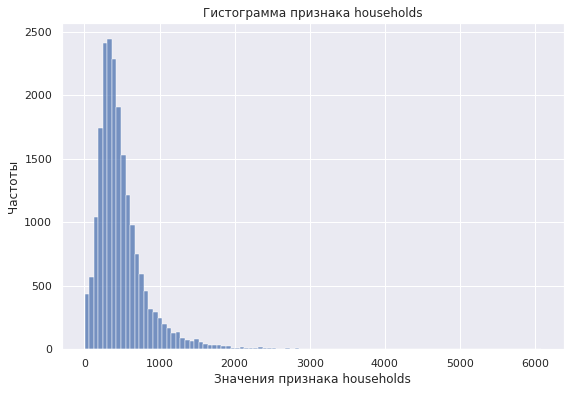

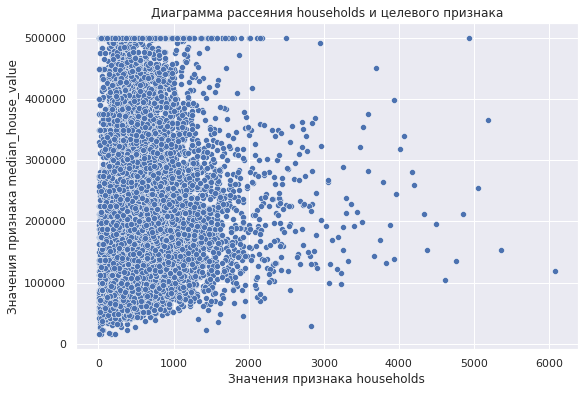


====== Признак median_income ======



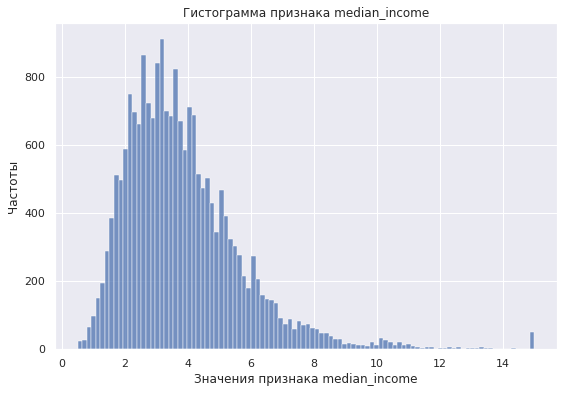

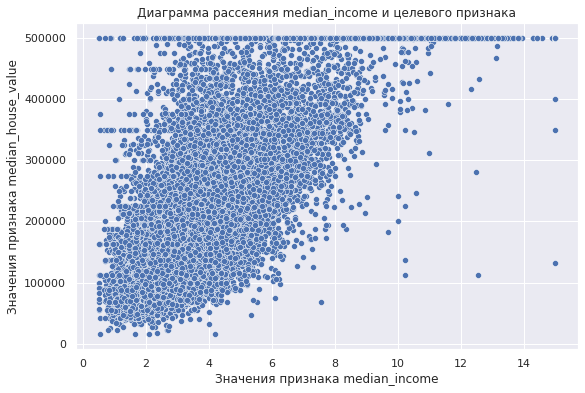

In [12]:
for column in num_cols:
    print(f'\n====== Признак {column} ======\n')
    column_data = df.select(column, target).sample(SAMPLE_SIZE).toPandas()

# построение гистограммы исследуемого признака    
    fig, ax = plt.subplots(figsize=(9, 6));
    plt.title(f'Гистограмма признака {column}');
    plt.ylabel('Частоты');
    plt.xlabel(f'Значения признака {column}');
    sns.histplot(column_data,
                x=column,
                bins=100,
                ax=ax);
    plt.show()
    
# построение диаграммы рассеяния исследуемого и целевого признаков
    fig, ax = plt.subplots(figsize=(9, 6));
    plt.title(f'Диаграмма рассеяния {column} и целевого признака');
    plt.ylabel(f'Значения признака {target}');
    plt.xlabel(f'Значения признака {column}');
    sns.scatterplot(data=column_data, x=column, y=target);
    plt.show()

В признаках `total_rooms`, `total_bedrooms`, `population`, `households` и `median_income` наблюдаются существенные выбросы справа. Диаграммы рассеяния показывают наличие нелинейных зависимостей между целевым и входными признаками. На диаграммах рассеяния заметно влияние аномальных значений целевого признака. Эти факторы могут отразиться на качестве обучения линейной модели.

In [13]:
df.filter(df['housing_median_age']==52).count()

1273

Кроме того, возможно, есть аномальное количество значений 52 в признаке `housing_median_age`, скорее всего, объясняющиеся теми же причинами, что и аномалии в целевом признаке. Этот фактор также может негативно отразиться на качестве линейной модели.

Посмотрим как будут выглядеть распределения признаков, если мы удалим данные с выбросами (отбросив значения за пределами приблизительно 99% перцентиля данных) и аномальными значениями целевого признака.

In [14]:
num_cols_transformed = [
            'total_rooms',
            'total_bedrooms',
            'population',
            'households',
            'median_income'
]


====== Признак total_rooms ======



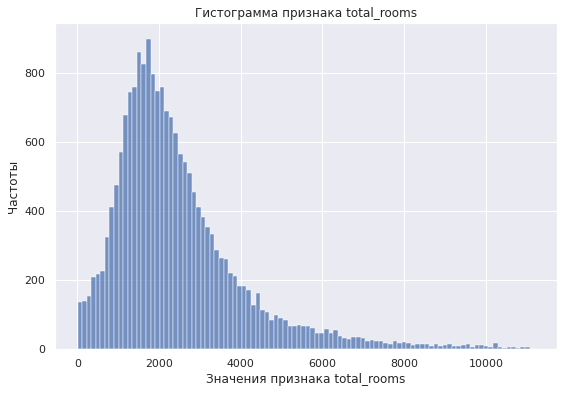

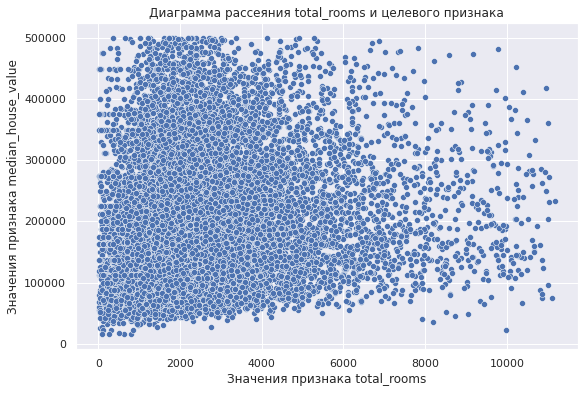


====== Признак total_bedrooms ======



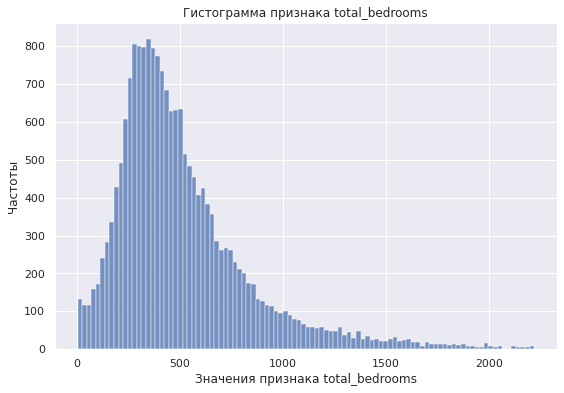

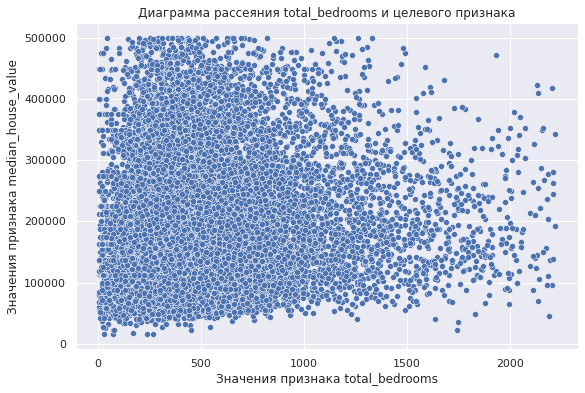


====== Признак population ======



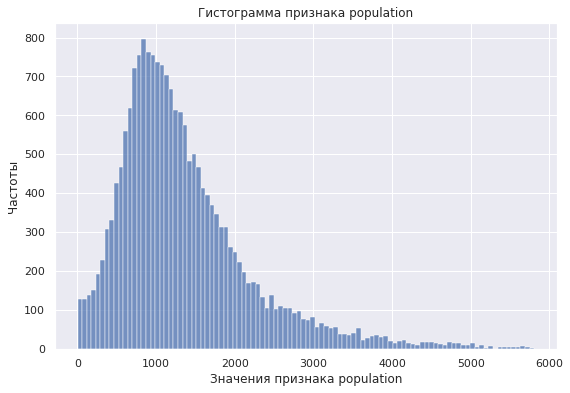

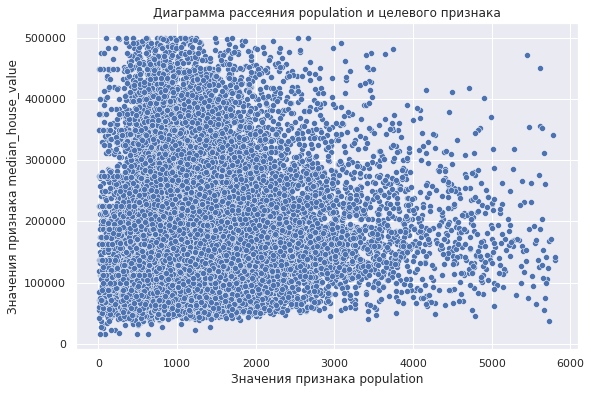


====== Признак households ======



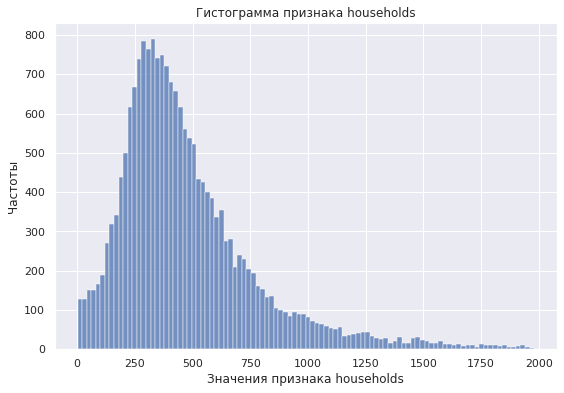

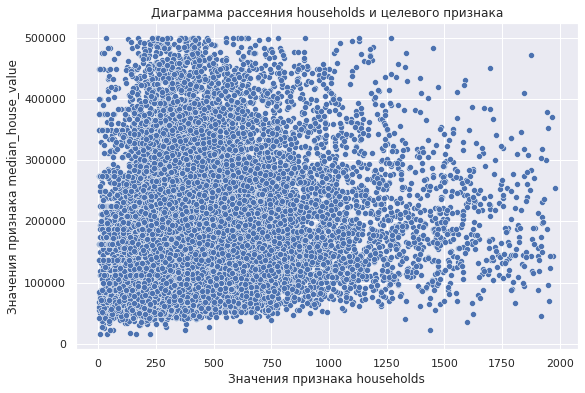


====== Признак median_income ======



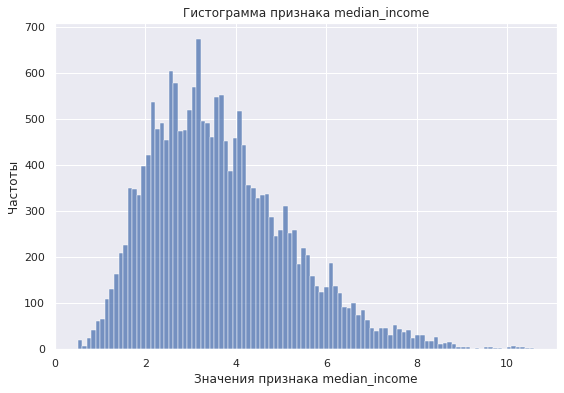

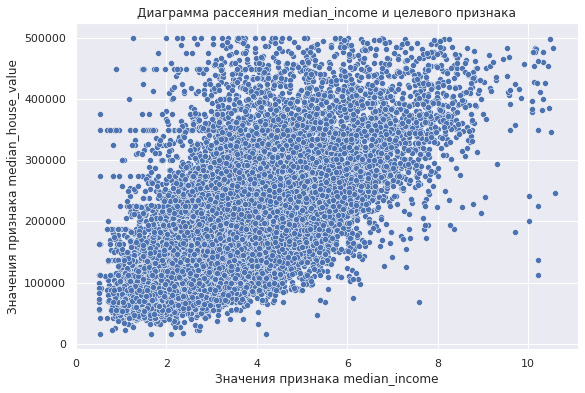

In [15]:
for column in num_cols_transformed:
    print(f'\n====== Признак {column} ======\n')
    
# вычислим примерный 99% перцентиль
    column_sample = df.select(column).sample(SAMPLE_SIZE).toPandas()
    perc_99 = column_sample[column].quantile(0.99)
    
# отбросим выбросы и аномалии
    column_data = df.filter(F.col(column) < perc_99) \
                    .filter(F.col(target) != 500001) \
                    .select(column, target) \
                    .sample(SAMPLE_SIZE) \
                    .toPandas()

# построение гистограммы исследуемого признака    
    fig, ax = plt.subplots(figsize=(9, 6));
    plt.title(f'Гистограмма признака {column}');
    plt.ylabel('Частоты');
    plt.xlabel(f'Значения признака {column}');
    sns.histplot(column_data,
                x=column,
                bins=100,
                ax=ax);
    plt.show()
    
# построение диаграммы рассеяния исследуемого и целевого признаков
    fig, ax = plt.subplots(figsize=(9, 6));
    plt.title(f'Диаграмма рассеяния {column} и целевого признака');
    plt.ylabel(f'Значения признака {target}');
    plt.xlabel(f'Значения признака {column}');
    sns.scatterplot(data=column_data, x=column, y=target);
    plt.show()

Распределение обработанных данных больше напоминают нормальное, диаграмма рассеяния для признака `median_income` наводит на мысль о некоторой корреляции с целевым признаком.

Взглянем на матрицу корреляции между признаками.

In [16]:
data_sampled = df.sample(SAMPLE_SIZE).toPandas()

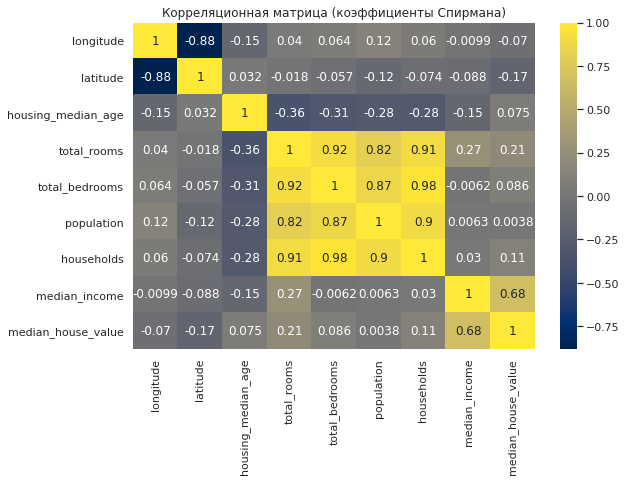

In [17]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.title('Корреляционная матрица (коэффициенты Спирмана)');
sns.heatmap(data_sampled[num_cols+[target]].corr(method='spearman'), annot=True, cmap='cividis');

Большинство признаков почти не коррелируют с целевым. У признаков `total_rooms`, `total_bedrooms`, `population`, `households` есть сильная положительная корреляция между собой, что вполне ожидаемо, поскольку все они по логике должны коррелировать с количеством населения в жилом массиве. Вместо `total_rooms`, `total_bedrooms`, `households` уместнее было бы, например, использовать синтетические признаки в виде соответствующих удельных величин на душу населения (то есть разделить значения этих признаков на соответствующие значения признака `population`). В то же время, у признака `median_income` действительно наблюдается положительная корреляция с целевым признаком. В целом, можно ожидать невысокий результат от используемой по ТЗ линейной регрессии на необработанных признаках по причине слабой корреляции почти всех числовых признаков с целевым, предположительного преобладания нелинейных зависимостей между ними, а также наличия выбросов и аномалий.

Синтезируем новые признаки в виде указанных выше удельных величин на основе `total_rooms`, `total_bedrooms`, `households`.

In [18]:
features_to_transform = ['total_rooms', 'total_bedrooms', 'households']
new_num_cols = []
for column in features_to_transform:
    new_num_cols.append(column + '_per_capita')
    df = df.withColumn(column + '_per_capita', F.col(column)/F.col('population'))
df.show(1)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------------+-------------------------+---------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|total_rooms_per_capita|total_bedrooms_per_capita|households_per_capita|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------------+-------------------------+---------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|     2.732919254658385|      0.40062111801242234|    0.391304347826087|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------------+----

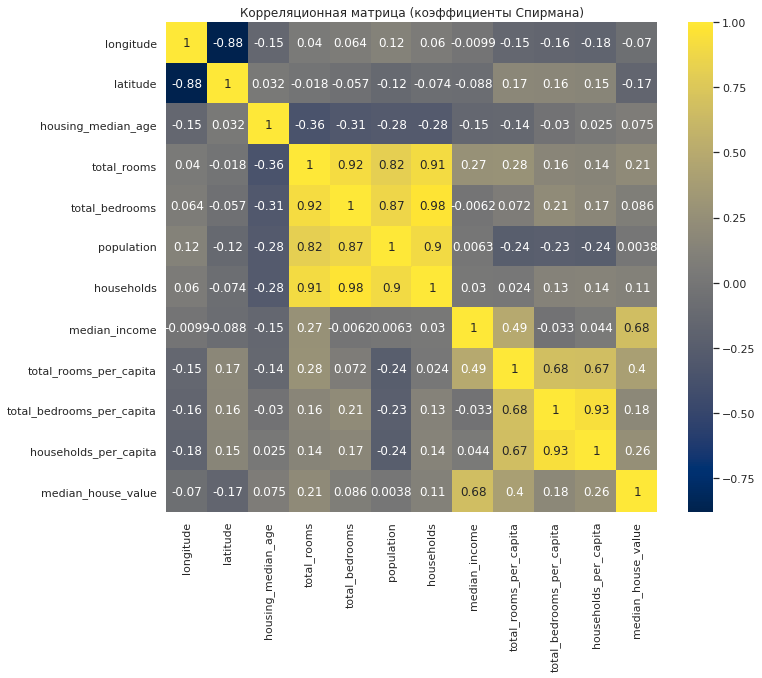

In [19]:
data_sampled = df.sample(SAMPLE_SIZE).toPandas()
fig, ax = plt.subplots(figsize=(11, 9))
plt.title('Корреляционная матрица (коэффициенты Спирмана)');
sns.heatmap(data_sampled[num_cols + new_num_cols + [target]].corr(method='spearman'),
            annot=True,
            cmap='cividis');

Трансформированные признаки значительно лучше коррелируют с целевым, кроме того, в отличии от исходных между ними не наблюдается мультиколлинеарности. Возможно, обучение модели на новых признаках даст более точные предсказания. Мы проверим это предположение в следующем разделе проекта.

**Итак, мы провели исследовательский анализ данных в ходе которого сделали следующие выводы:**
 - **В целевом признаке имеется около тысячи значений 500001, что, скорее всего, является следствием того, что жилым массивам со значением целевого признака большим 500000 были присвоены значения 500001. Этот факт негативно скажется на предсказательной способности линейной регрессии, обученной на всех данных.**
 - **В признаках `total_rooms`, `total_bedrooms`, `population`, `households` и `median_income` наблюдаются существенные выбросы справа. Диаграммы рассеяния показывают наличие нелинейных зависимостей между целевым и входными признаками. На диаграммах рассеяния заметно влияние аномальных значений целевого признака. Эти факторы могут отразиться на качестве обучения линейной модели.**
 - **Большинство признаков почти не коррелируют с целевым. У признаков `total_rooms`, `total_bedrooms`, `population`, `households` есть сильная положительная корреляция между собой, что вполне ожидаемо, поскольку все они по логике должны коррелировать с количеством населения в жилом массиве. На основе `total_rooms`, `total_bedrooms`, `households` мы создали синтетические признаки в виде соответствующих удельных величин на душу населения (то есть разделить значения этих признаков на соответствующие значения признака `population`).**
 - **В то же время, у признака `median_income` действительно наблюдается положительная корреляция с целевым признаком. В целом, можно ожидать невысокий результат от используемой по ТЗ линейной регрессии на необработанных признаках по причине слабой корреляции почти всех числовых признаков с целевым, предположительного преобладания нелинейных зависимостей между ними, а также наличия выбросов и аномалий.**

## Пайплайн

Настало время подобрать и обучить модели линейной регрессии. Мы осуществим эти шаги в пайплайне, в котором заполним пропуски, произведем трансформацию категориальных признаков, масштабирование числовых признаков, инициализируем модель линейной регрессиии и подберем для нее оптимальные гипермараметры с помощью перебора с кроссвалидацией по метрике RMSE. Для удобства поместим пайплайн в функцию.

In [20]:
df.count()

20640

In [21]:
# подготовим данные
data = df

# список названий признаков, подаваемых в estimator
final_features = ['categorical_features','numerical_features_scaled']

# разделим данные на выборки
train_data, test_data = data.randomSplit([1 - TEST_SIZE, TEST_SIZE], seed=RANDOM_STATE)
print(train_data.count(), test_data.count())

16573 4067


In [22]:
def pipe(num_cols, final_cols, cat_cols=None):
# инициализация трансформера категориальныз признаков в числовые
    if cat_cols:
        indexer = StringIndexer(handleInvalid='keep',
                                inputCols=cat_cols, 
                                outputCols=[c+'_idx' for c in cat_cols])

# one-hot кодирование преобразованных категориальных признаков
        if int(pyspark_version[:1]) == 3:
            encoder = OneHotEncoder(inputCols=[c+'_idx' for c in cat_cols],
                                    outputCols=[c+'_ohe' for c in cat_cols])    
        elif int(pyspark_version[:1]) == 2:
            encoder = OneHotEncodeEstimator(inputCols=[c+'_idx' for c in cat_cols],
                                            outputCols=[c+'_ohe' for c in cat_cols])
    
# объединение категориальных признаков в один вектор
        categorical_assembler = \
            VectorAssembler(inputCols=[c+'_ohe' for c in cat_cols],
                            outputCol="categorical_features")
    
# заполнение пропущенных значений числовых признаков
    imputer = Imputer(inputCols=num_cols,
                      outputCols=num_cols,
                      strategy='median')

# объединение числовых признаков в один вектор
    numerical_assembler = VectorAssembler(inputCols=num_cols,
                                          outputCol="numerical_features")

# масштабирование числовых признаков
    standard_scaler = StandardScaler(inputCol='numerical_features',
                                     outputCol="numerical_features_scaled")

# собираем набор признаков для передачи модели
    final_assembler = VectorAssembler(inputCols=final_features, 
                                      outputCol="features")

# инициализация модели оценщика
    lr = LinearRegression(
                      standardization=False,
                      predictionCol='prediction',
                      labelCol=target,
                      featuresCol='features'
    )

# задание метрики оценки
    evaluator = RegressionEvaluator(predictionCol='prediction',
                                    labelCol=target)

    grid_search = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.01, 0.1]) \
        .addGrid(lr.elasticNetParam, [0.5, 1.0]) \
        .addGrid(lr.maxIter, [100, 200]) \
        .build()                                

# подготовка кроссвалидации с GridSearch
    cv = CrossValidator(estimator=lr,
                        estimatorParamMaps=grid_search,
                        evaluator=evaluator,
                        seed=RANDOM_STATE)

# инициализация пайплайна
    if cat_cols:
        pipeline = Pipeline(stages=[
                            indexer, 
                            encoder, 
                            categorical_assembler, 
                            imputer,
                            numerical_assembler,
                            standard_scaler,
                            final_assembler,
                            cv
        ])
    else:
        pipeline = Pipeline(stages=[
                            imputer,
                            numerical_assembler,
                            standard_scaler,
                            final_assembler,
                            cv
        ])        
    
    return pipeline

Обучим модель на числовых и категориальных признаках тренировочных данных.

In [23]:
model_1 = pipe(num_cols, final_features, cat_cols).fit(train_data)

24/10/24 13:22:45 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/10/24 13:22:45 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Сделаем предсказания на тестовых данных.

In [24]:
predictions = model_1.transform(test_data)

Напишем функцию для вывода результатов.

In [ ]:
def show_results(model, predictions):
    
    predictedLables = predictions.select(target, 'prediction')
    print('\nПредсказания модели:')
    predictedLables.show()

# выведем метрику RMSE лучшей модели на кроссвалидации
    print(f'Метрика RMSE лучшей модели на кроссвалидации: '
          f'{model.stages[-1].bestModel.summary.rootMeanSquaredError}')

# выведем параметры лучшей модели
    print('\nПараметры лучшей модели:')
    display(model.stages[-1].bestModel.extractParamMap())

    print("Коэффициенты модели: %s" % str(model.stages[-1].bestModel.coefficients))
    print("Intercept: %s" % str(model.stages[-1].bestModel.intercept))

# выведем метрики модели на тестовой выборке

# подготовка датасета для оценки
    results = predictions.select(['prediction', target])
    results_collect = results.collect()
    results_list = [ (float(i[0]), float(i[1])) for i in results_collect]
    scoreAndLabels = spark.sparkContext.parallelize(results_list)

# инициализируем метрики
    metrics = RegressionMetrics(scoreAndLabels)

    print('\nМетрики на тестовой выборке:')

# Root mean squared error
    print("RMSE = %s" % metrics.rootMeanSquaredError)

# R-squared
    print("R-squared = %s" % metrics.r2)

# MAE
    print("MAE = %s" % metrics.meanAbsoluteError)

Выведем результаты первой модели.

In [26]:
show_results(model_1, predictions)


Предсказания модели:
+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           70500.0|143150.62142669223|
|           70500.0|163354.37829324976|
|           62500.0|165277.25237336522|
|           85100.0| 178602.6314381063|
|           85600.0| 187602.1937511298|
|           86400.0|192048.82106271246|
|           92800.0|209051.01327571878|
|           86900.0|150810.52245958243|
|           55000.0|   213836.94129497|
|          111800.0|216084.71286088694|
|           70500.0| 172241.9799944847|
|           75000.0|114287.88731632428|
|          105800.0|167655.79187793378|
|           78800.0|133716.62202049932|
|          111300.0|156814.28741982626|
|           99200.0|166652.02052830346|
|           95200.0|197037.58092303295|
|          133900.0|200947.43187713344|
|           98800.0|177212.92863005865|
|          140500.0|225156.44906473393|
+------------------+------------------+
only showing top 2

{Param(parent='LinearRegression_6d10442b343e', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_6d10442b343e', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0,
 Param(parent='LinearRegression_6d10442b343e', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_6d10442b343e', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearRegression_6d10442b343e', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_6d10442b343e', name='labelCol', doc='label column name.'): 'median_house_value',
 Param(parent='LinearRegression_6d10442b343e', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber.'): 

Коэффициенты модели: [14758.683233035292,-24171.21443893137,18584.646643519423,8850.504534366824,169318.25126206718,-53879.70581970863,-54874.75058645421,13589.537831937989,-10937.453333923639,29313.993700503965,-46067.76190005693,32624.763265706337,73764.34161217613]
Intercept: -2283235.4223384764



Метрики на тестовой выборке:
RMSE = 67985.61232087806
R-squared = 0.6487844351721541
MAE = 49316.196190645554


Как и ожидалось, модель показала невысокие, хотя и удовлетворительные результаты. Средняя величина ошибки превышает 20% от среднего значения целевого признака. Значительное превышение метрики RMSE над MAE может свидетельствовать о существенном влиянии выбросов и аномалий в значениях признаков на качество модели. Упрощая, можно сказать, что модель предсказния модели примерно в 65% лучше, чем предсказания модели простого среднего.

Теперь подберем модель без использования категориальных признаков.

In [27]:
final_features = ['numerical_features_scaled']

Инициализируем пайплайн с новым параметром `final_features`, cделаем предсказания на тестовых данных и выведем результаты.

In [28]:
model_2 = pipe(num_cols, final_features).fit(train_data)

In [30]:
predictions = model_2.transform(test_data)

show_results(model_2, predictions)


Предсказания модели:
+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           70500.0|110419.13843726926|
|           70500.0|131426.52636225754|
|           62500.0|133744.65612235572|
|           85100.0|149764.34144898225|
|           85600.0|155960.67413851712|
|           86400.0| 159621.9286741335|
|           92800.0|176808.49319610978|
|           86900.0|117506.16350499494|
|           55000.0|191568.62454398395|
|          111800.0|184806.93928650068|
|           70500.0|148321.39386055572|
|           75000.0| 78917.84759489121|
|          105800.0|133414.09550281195|
|           78800.0|  97960.1563290297|
|          111300.0| 118808.9119324768|
|           99200.0| 131824.9527667272|
|           95200.0| 170344.1345577445|
|          133900.0| 169640.6791854417|
|           98800.0|145269.72501492966|
|          140500.0|214924.14184997138|
+------------------+------------------+
only showing top 2

{Param(parent='LinearRegression_4428a6260a6b', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_4428a6260a6b', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0,
 Param(parent='LinearRegression_4428a6260a6b', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_4428a6260a6b', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearRegression_4428a6260a6b', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_4428a6260a6b', name='labelCol', doc='label column name.'): 'median_house_value',
 Param(parent='LinearRegression_4428a6260a6b', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber.'): 

Коэффициенты модели: [-84800.72278219568,-90590.19923988862,14490.315079144055,-15040.665755493284,33196.09890158499,-46670.62303686873,33345.95378362689,75532.6435584706]
Intercept: -3535468.062730975

Метрики на тестовой выборке:
RMSE = 69085.65153822895
R-squared = 0.6373268178483251
MAE = 50512.04256141765


In [31]:
model_2.stages

[ImputerModel: uid=Imputer_fbc8e8926d78, strategy=median, missingValue=NaN, numInputCols=8, numOutputCols=8,
 VectorAssembler_bd2db3eb9f62,
 StandardScalerModel: uid=StandardScaler_79db08b591f6, numFeatures=8, withMean=false, withStd=true,
 VectorAssembler_d2c976c3c183,
 CrossValidatorModel_4ca115ca8f56]

Выведение из рассмотрения категориального признака ухудшило все метрики модели, данный признак лучше сохранить.

Теперь запустим пайплайн с трансформированными признаками (вместо исходных).

In [32]:
num_cols = [x for x in num_cols if x not in features_to_transform] + new_num_cols

final_features = ['categorical_features','numerical_features_scaled']

model_3 = pipe(num_cols, final_features, cat_cols).fit(train_data)

predictions = model_3.transform(test_data)

show_results(model_3, predictions)


Предсказания модели:
+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           70500.0|134924.05200468842|
|           70500.0|    158409.5802952|
|           62500.0| 165090.4498774372|
|           85100.0|188822.56747590099|
|           85600.0|183240.90150103858|
|           86400.0| 182622.9770618421|
|           92800.0|211903.29862305243|
|           86900.0| 137167.2741154302|
|           55000.0|191390.35219489643|
|          111800.0| 203423.5348856598|
|           70500.0|171781.51935504656|
|           75000.0|125377.77258961974|
|          105800.0|177435.95215696935|
|           78800.0|126509.21440966986|
|          111300.0|140689.44095413154|
|           99200.0|166361.41592658777|
|           95200.0|195168.50405454915|
|          133900.0|196754.48450356163|
|           98800.0|166877.68766766554|
|          140500.0|222301.89052906446|
+------------------+------------------+
only showing top 2

{Param(parent='LinearRegression_728e4b804b64', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_728e4b804b64', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5,
 Param(parent='LinearRegression_728e4b804b64', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_728e4b804b64', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearRegression_728e4b804b64', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_728e4b804b64', name='labelCol', doc='label column name.'): 'median_house_value',
 Param(parent='LinearRegression_728e4b804b64', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber.'): 

Коэффициенты модели: [16238.882285521719,-20126.83149989324,12581.174689819603,4745.138964604569,153141.4673995433,-59105.22170945676,-62341.20190770721,13332.037581339508,5330.904903829952,72306.92456514057,-1203.9565725798238,6965.420614870244,28124.423294283635]
Intercept: -2585308.154635841

Метрики на тестовой выборке:
RMSE = 65570.92128328778
R-squared = 0.6732900970102782
MAE = 47731.82819341127


In [33]:
model_3.stages

[StringIndexerModel: uid=StringIndexer_07cce3992739, handleInvalid=keep, numInputCols=1, numOutputCols=1,
 OneHotEncoderModel: uid=OneHotEncoder_fe04e6a68d2c, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1,
 VectorAssembler_6da05982ebbc,
 ImputerModel: uid=Imputer_63086f1723bf, strategy=median, missingValue=NaN, numInputCols=8, numOutputCols=8,
 VectorAssembler_f04a9e8e2fa8,
 StandardScalerModel: uid=StandardScaler_a0a1fbc50bc7, numFeatures=8, withMean=false, withStd=true,
 VectorAssembler_d9f15d35b8d4,
 CrossValidatorModel_78e4c96de9e1]

Используемые метрики показывают улучшение предсказательной силы модели, что свидетельствует о продуктивности подхода с синтезом новых признаков. Мы останавливаем свой выбор на последней из пртестированных моделей линейной регрессии. Также отметим, что наличие нелинейных связей между входными и целевым признаками и невысокие значения коэффициентов корреляции Спирмана между ними говорит в пользу использования нелинейных моделей МО (например, деревьев решений) для производства более точных предсказаний.

In [34]:
spark.stop()

**Итак, согласно ТЗ, была выбрана модель линейной регрессии библиотеки `pyspark.ml` с использованием синтетических признаков, давшая наилучшие показатели метрик (RMSE = 65570.92128328778, R-squared = 0.6732900970102782, MAE = 47731.82819341127) на тестовых данных и использующая синтетические признаки: `total_rooms_per_capita`, `total_bedrooms_per_capita`, `households_per_capita`, созданные из признаков `total_rooms`, `total_bedrooms`, `households` соответственно, путем деления их значений на соответствующие значения признака `population`. Параметры лучшей модели: maxIter=200, regParam=0.01, elasticNetParam=1.0.**

## Вывод

Мы провели предобработку и исследовательский анализ данных в ходе которых предприняли следующие шаги и сделали следующие выводы:
 - Мы обнаружили и избавились от пропусков в данных, заполнив их медианными значениями.
 - В целевом признаке имеется около тысячи значений 500001, что, скорее всего, является следствием того, что жилым массивам со значением целевого признака большим 500000 были присвоены значения 500001. Этот факт негативно сказался на предсказательной способности линейной регрессии, обученной на всех данных.
 - В признаках `total_rooms`, `total_bedrooms`, `population`, `households` и `median_income` наблюдаются существенные выбросы справа. Диаграммы рассеяния показывают наличие нелинейных зависимостей между целевым и входными признаками. На диаграммах рассеяния заметно влияние аномальных значений целевого признака. Эти факторы могли негативно отразиться на качестве обучения линейной модели.
 - Большинство признаков почти не коррелируют с целевым. У признаков `total_rooms`, `total_bedrooms`, `population`, `households` есть сильная положительная корреляция между собой, что вполне ожидаемо, поскольку все они по логике должны коррелировать с количеством населения в жилом массиве. На основе `total_rooms`, `total_bedrooms`, `households` мы создали синтетические признаки в виде соответствующих удельных величин на душу населения (то есть разделить значения этих признаков на соответствующие значения признака `population`).
 - В то же время, у признака `median_income` действительно наблюдается положительная корреляция с целевым признаком. Мы заключили, что, в целом, можно ожидать невысокий результат от используемой по ТЗ линейной регрессии на необработанных признаках по причине слабой корреляции почти всех числовых признаков с целевым, предположительного преобладания нелинейных зависимостей между ними, а также наличия выбросов и аномалий.

Далее, мы подобрали и обучили модели линейной регрессии. Мы осуществим эти шаги в пайплайне, в котором производили трансформацию категориальных признаков, масштабирование числовых признаков, инициализацию модели линейной регрессиии и подбирали для нее оптимальные гипермараметры с помощью перебора с кроссвалидацией по метрике RMSE.

Согласно ТЗ, была выбрана модель линейной регрессии библиотеки `pyspark.ml` с использованием синтетических признаков, давшая наилучшие показатели метрик (RMSE = 65570.92128328778, R-squared = 0.6732900970102782, MAE = 47731.82819341127) на тестовых данных и использующая синтетические признаки: `total_rooms_per_capita`, `total_bedrooms_per_capita`, `households_per_capita`, созданные из признаков `total_rooms`, `total_bedrooms`, `households` соответственно, путем деления их значений на соответствующие значения признака `population`. Параметры лучшей модели: maxIter=200, regParam=0.01, elasticNetParam=1.0.

В заключение отметим, что наличие нелинейных связей между входными и целевым признаками и невысокие значения коэффициентов корреляции Спирмана между ними говорит в пользу использования нелинейных моделей МО (например, деревьев решений) для производства более точных предсказаний в будущем.